## 🔹 Step 1: Setup & Install Dependencies
* Before running the script, ensure you have Hugging Face Transformers and Datasets installed:

In [ ]:
!pip install transformers datasets torch

## 🔹 Step 2: Import Required Libraries
### Required libraries :

* `AutoModelForSequenceClassification`: Loads a pre-trained transformer-based model for classification.


*   `AutoTokenizer`: Handles text tokenization to convert raw text into model-readable format.

*   `Trainer`: A high-level API for fine-tuning transformer models.
TrainingArguments: Defines training parameters (learning rate, batch size, epochs, etc.).

* `load_dataset:` Loads pre-built datasets from Hugging Face’s datasets library.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch
import os
from datasets import load_dataset
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

## 🔹 Step 3: Disable Parallelism Warning
This prevents tokenizer parallelism issues that can cause deadlocks in multi-threaded environments.

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 🔹 Step 4: Load the Pre-trained Model and Tokenizer
* `AutoTokenizer.from_pretrained(model_name)`: Loads a pre-trained tokenizer (DistilRoBERTa).

* `AutoModelForSequenceClassification.from_pretrained(model_name)`: Loads a pre-trained sentiment model.
* `emotion_labels`: Defines 7 emotion categories that the model will classify.


In [ ]:
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,from_tf=True)
emotion_labels = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]


## 🔹Step 5: Load the GoEmotions Dataset
 * `go_emotions`: A dataset from Google containing 58k English Reddit comments, labeled with emotions.

In [ ]:
dataset = load_dataset("go_emotions")

README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
print(dataset['train'][:5])

{'text': ["My favourite food is anything I didn't have to cook myself.", 'Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead', 'WHY THE FUCK IS BAYLESS ISOING', 'To make her feel threatened', 'Dirty Southern Wankers'], 'labels': [[27], [27], [2], [14], [3]], 'id': ['eebbqej', 'ed00q6i', 'eezlygj', 'ed7ypvh', 'ed0bdzj']}


## 🔹 Step 6: Preprocess the Dataset

1. Preprocessing:
    * The p`reprocess_data` function converts raw text into tokenized inputs for the model.
    * ` truncation=True`: Ensures input is within model limits (max 512 tokens).
    * `padding=True`: Ensures consistent input size in batches.
2. Applying to Dataset:
    * `.map(preprocess_function, batched=True)`: Applies the function to all samples.
    * `batched=True`: This indicates that the `preprocess_data` function will be applied to batches of samples at once for increased efficiency.


In [ ]:
def preprocess_data(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)


encoded_dataset = dataset.map(preprocess_data, batched=True)


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

## 🔹 Step 7: Emotion Analysis Function
1. Tokenization: Converts text into model-friendly format.
2. Model Prediction:
    * `return_tensors="pt"`: Ensures Compatibility with PyTorch Models
    * `output.logits`: Raw model scores.
    * `torch.softmax(..., dim=1)`: Converts scores to probabilities.
    * `.squeeze()`: a tensor operation that removes dimensions of size 1 from the tensor. This helps simplify the tensor shape while keeping its data unchanged.
3. Get Top-3 Emotions:
    * `sorted_indices`: Sorts emotions by probability.
    * Returns top 3 emotions with scores.

In [ ]:
def emotions_analysis(text):
    input = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        output = model(**input)
        scores = torch.softmax(output.logits, dim=1).squeeze().tolist()
    sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    top_emotions = [(emotion_labels[i], scores[i]) for i in sorted_indices[:3]]

    return top_emotions


## 🔹 Step 8: Run Emotion Detection

In [ ]:
text = "It was an amazing day"
detected_emotions = emotions_analysis(text)

# Print detected emotions with scores
print("Detected Emotions:")
for emotion, score in detected_emotions:
    print(f"{emotion}: {score:.4f}")
top_emotion = detected_emotions[0][0]
print(f"Top Emotion: {top_emotion}")


Detected Emotions:
joy: 0.7235
surprise: 0.2383
neutral: 0.0196
Top Emotion: joy


## 🔹 Step 9: Load dataset

In [ ]:

def remove_duplicate_rows(input_file):
    try:
        df = pd.read_csv(input_file)
        df_no_duplicates = df.drop_duplicates()
        return df_no_duplicates
    except FileNotFoundError:
        print(f"Error: Input file '{input_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

input_csv_file = "dataset.csv"
dataset = remove_duplicate_rows(input_csv_file)


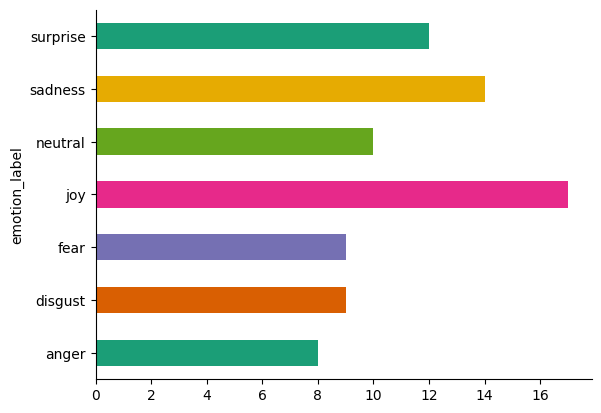

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
dataset.groupby('emotion_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## 🔹 Step 10: Suggest emojis

In [ ]:
def suggest_emojis(emotion):
    emotion_df = dataset[dataset["emotion_label"] == emotion]
    if emotion_df.empty:
        return f"Sorry, no emojis found for the emotion '{emotion}'."

    # Randomly sample 3 emojis (or fewer if less than 3 exist)
    sampled_emojis = emotion_df["emoji"].sample(n=min(3, len(emotion_df)), random_state=None).tolist()

    return f"{' , '.join(sampled_emojis)}"

In [ ]:
suggestions = suggest_emojis(top_emotion)
suggestions

'✨ , 😆 , 😁'

In [ ]:
color_map = {
    "anger": "tomato",
    "disgust": "palegreen",
    "fear": "plum",
    "joy": "lemonchiffon",
    "neutral": "lightgray",
    "sadness": "lightblue",
    "surprise": "gold"
}

input_text = widgets.Textarea(
    placeholder='Enter your text here...',
    description='Text:',
    layout=widgets.Layout(width='500px', height='100px')
)
analyze_button = widgets.Button(description='Analyze Emotion')

output_area = widgets.HTML(
    value='<div style="background-color: lightgray; color:black; padding: 15px; border-radius: 5px;">Enter text and click "Analyze Emotion" to see results.</div>',
    layout=widgets.Layout(width='500px')
)

# Define the callback function for the button click
def on_analyze_button_clicked(b):
    text = input_text.value.strip()
    if not text:
        output_area.value = '<div style="background-color: lightcoral; padding: 15px; border-radius: 5px;"><b>Detected Emotion:</b> Please enter some text.<br>Suggested Emojis: </div>'
        return
    detected_emotions = emotions_analysis(text)
    top_emotion = detected_emotions[0][0]
    suggestions = suggest_emojis(top_emotion)
    color = color_map.get(top_emotion, "white")
    output_area.value = f'<div style="background-color: {color} ; color:black; padding: 15px; border-radius: 5px;"><b>Detected Emotion:</b> {top_emotion}<br>Suggested Emojis: {suggestions}</div>'

# Set the button's on_click event
analyze_button.on_click(on_analyze_button_clicked)

# Layout the widgets vertically
vbox = widgets.VBox([input_text, analyze_button, output_area])

# Display the GUI
display(vbox)